In [1]:
import os
import pandas as pd
import shutil, os
import numpy as np
import pandas as pd
# import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer, MultiLabelBinarizer

import tensorflow as tf
# from tensorflow.keras.layers import Dropout, Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
# from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session

import keras
from keras import backend as K
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam

### model py files
import CNN_Baseline as baseline
import CNN_C as dropout
import CNN_D as batchN
import CNN_E as mobnet
import CNN_E as vgg16

In [2]:
### Choose which GPU to use - HEX SERVER ONLY. Go to https://hex.cs.bath.ac.uk/usage for current usage
# import os 
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

### Prevent GPU memory overflow
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)


# ### For M1 Mac only
# # Import mlcompute module to use the optional set_mlc_device API for device selection with ML Compute.
# from tensorflow.python.compiler.mlcompute import mlcompute

# # Select CPU device.
# mlcompute.set_mlc_device(device_name='gpu') # Available options are 'cpu', 'gpu', and 'any'.

In [3]:
INPUT_SHAPE = (128, 128, 3) # Image Dimensions
BATCH_SIZE = 128
DROPOUT_RATE = 0.5
EPOCHS = 50
LR = 0.0001 # Learning Rate
REG_STRENGTH = 0.01 # Regularization Strength
WORKERS = 4 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

In [26]:
DATASET_PATH = 'dataset/'
TRAIN_PATH = DATASET_PATH + 'train_file'
TEST_PATH = DATASET_PATH + 'test_file'

TRAIN_CSV_PATH = DATASET_PATH + 'train_label.csv'
TEST_CSV_PATH = DATASET_PATH + 'test_label.csv'

In [5]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

df_train['image_name'] = df_train['image_name'].astype(str)
df_test['image_name'] = df_test['image_name'].astype(str)

df_train['tags'] = df_train['tags'].apply(lambda x: x.split(' '))
df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

X_train_files_o = np.array(df_train['image_name'].tolist()) # filenames
X_train_files_o.reshape((X_train_files_o.shape[0], 1))
y_train_o = np.array(df_train['tags'].tolist(), dtype=object) # train image tags (ground truth)
y_test_o = np.array(df_test['tags'].tolist(), dtype=object) # test image tags (ground truth)

In [7]:
# check labels in tags and how many there are
tags = df_train['tags'].values

flat_list = [item for sublist in tags for item in sublist]
tags_unique, tags_count = np.unique(flat_list, return_counts=True)
labels = list(tags_unique)

print(labels)
print()
print(len(labels), "unique tags")

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']

17 unique tags


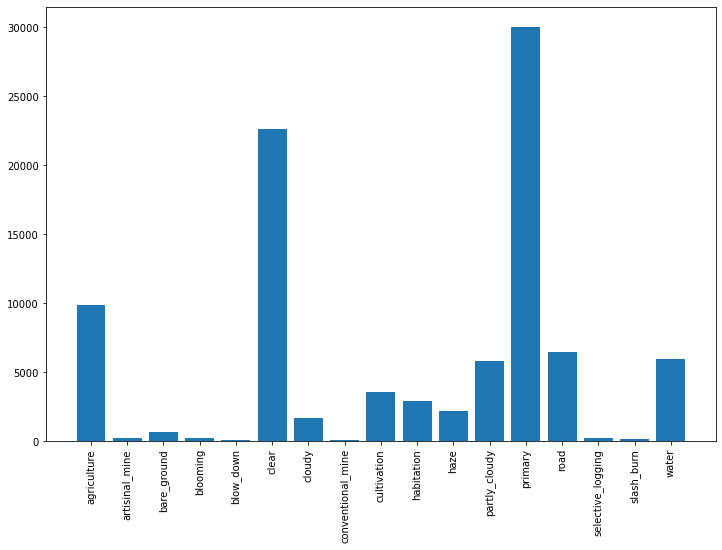

In [8]:
# Distribution of the labels

plt.figure(figsize=(12, 8))
            
plt.bar(range(len(tags_count)), list(tags_count), align='center')
plt.xticks(range(len(tags_count)), list(labels), rotation=90)

plt.show()

In [9]:
# Define learning curve and evaluation metric (f-2 Beta score):

def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

# F-Beta Score
def fbeta_score_K(y_true, y_pred):
    beta = 2
    beta_squared = beta ** 2
    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

from sklearn.metrics import fbeta_score


def calc_acc(y_test, y_pred, labels=labels, threshold=0.2):
    
    array_labels = np.array(labels)
    test = y_test
    pred = y_pred
    
    # Binarize pred to 0 and 1...
    binarizer = Binarizer(threshold=threshold)
    pred = binarizer.fit_transform(pred)
    # 0 and 1 to False and True for boolean indexing...
    pred = pred > 0
    
    preds = []
    for row in pred:
        preds.append(array_labels[row])
    
    mlb = MultiLabelBinarizer(classes=array_labels)
    
    test = mlb.fit_transform(test)
    preds = mlb.transform(preds)
    score = fbeta_score(test, preds, beta=2, average='weighted')
    
    return score


def plot(result, csv_filename):
    train_history = pd.DataFrame(result)

    train_history.to_csv(csv_filename, sep=',')
    plt.plot(train_history['fbeta_score_K'])
    plt.plot(train_history['val_fbeta_score_K'])
    plt.title('model accuracy')
    plt.ylabel('fbeta_score_K')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(train_history['loss'])
    plt.plot(train_history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [29]:
df_test

,image_name,tags
0,test_32752.jpg,"[clear, primary]"
1,test_7767.jpg,"[clear, primary]"
2,test_4254.jpg,"[agriculture, clear, cultivation, primary]"
3,test_23119.jpg,"[clear, primary]"
4,test_22101.jpg,"[agriculture, clear, primary]"
...,...,...
8091,test_14994.jpg,"[clear, primary]"
8092,test_12945.jpg,"[haze, primary]"
8093,test_9238.jpg,"[clear, primary]"
8094,test_36600.jpg,[cloudy]


In [31]:
y_test_o

array([list(['clear', 'primary']), list(['clear', 'primary']),
       list(['agriculture', 'clear', 'cultivation', 'primary']), ...,
       list(['clear', 'primary']), list(['cloudy']),
       list(['clear', 'primary'])], dtype=object)

In [10]:
def data_generator(X_train_files_o, y_train_o, base_flg):
    X_train_files, X_val_files, y_train, y_val = train_test_split(X_train_files_o, y_train_o, test_size=0.2, random_state=0)

    train_df = pd.DataFrame(list(zip(X_train_files, y_train)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files, y_val)), columns = ['image_name', 'tags'])

    train_df['tags'] = train_df['tags']
    val_df['tags'] = val_df['tags']
    
    if base_flg == 1:
        train_datagen = ImageDataGenerator(
            rescale=1./255
            )
    else:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
            )
        
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        )

    val_datagen = ImageDataGenerator(
        rescale=1./255
        )

    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        )

    test_datagen = ImageDataGenerator(
        rescale=1./255
        )

    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        directory=TEST_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        shuffle=False,
        )
    return train_generator,val_generator,test_generator

### CNN Baseline

In [27]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,1)
model_path = 'CNN_Baseline_weights' + '.h5'


adam = Adam(learning_rate=LR)

cnn_base_model = baseline.create_model()

clear_session()

cnn_base_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
]

history = cnn_base_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

# print('here', history.history.keys())


cnn_base_model.load_weights(model_path)

y_pred_b = cnn_base_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

In [28]:
plot(history.history,'CNN_Baseline_train_history.csv')
print("Test Accuracy Score", calc_acc(y_test_o, y_pred_b))

Test Accuracy Score 0.8615274766955602


### CNN_Baseline + Haze removed data

In [16]:
### Import haze removed dataset
DATASET_PATH = 'dataset-haze-removed/'
TRAIN_PATH = DATASET_PATH + 'train_file'
TEST_PATH = DATASET_PATH + 'test_file'

In [18]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o, 1)
model_path = 'CNN_Baseline_haze_weights' + '.h5'


adam = Adam(learning_rate=LR)

cnn_base_model = baseline.create_model()

clear_session()

cnn_base_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
]

history = cnn_base_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())


cnn_base_model.load_weights(model_path)

y_pred_b_hr = cnn_base_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/50
203/203 [==============================] - 49s 237ms/step - loss: 0.3779 - fbeta_score_K: 0.4900 - val_loss: 0.2356 - val_fbeta_score_K: 0.5738
Epoch 2/50
203/203 [==============================] - 48s 238ms/step - loss: 0.2174 - fbeta_score_K: 0.6087 - val_loss: 0.1855 - val_fbeta_score_K: 0.6763
Epoch 3/50
203/203 [==============================] - 49s 240ms/step - loss: 0.1862 - fbeta_score_K: 0.6724 - val_loss: 0.1722 - val_fbeta_score_K: 0.6799
Epoch 4/50
203/203 [==============================] - 49s 242ms/step - loss: 0.1686 - fbeta_score_K: 0.7033 - val_loss: 0.1687 - val_fbeta_score_K: 0.7119
Epoch 5/50
203/203 [==============================] - 49s 241ms/step - loss: 0.1632 - fbeta_score_K: 0.7163 - val_loss: 0.1623 - val_fbeta_score_K: 0.7277
Epoch 6/50
203/203 [==================

In [20]:
y_pred_b_hr = y_pred_base_haze

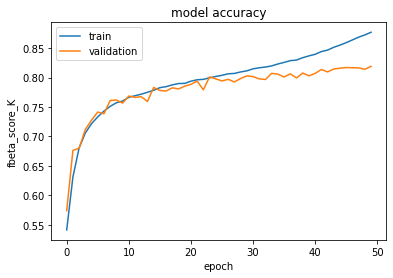

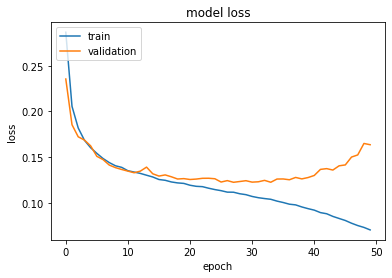

Test Accuracy Score 0.8615274766955602


In [21]:
plot(history.history,'CNN_Baseline_haze_train_history.csv')
print("Test Accuracy Score",calc_acc(y_test_o, y_pred_b_hr))

### A. CNN_Baseline + Haze Removal + Data Augmentation

In [ ]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o, 0)

model_path = 'CNN_A_weights' + '.h5'

adam = Adam(learning_rate=LR)

cnn_base_model = baseline.create_model()

clear_session()

cnn_base_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
]

history = cnn_base_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())


cnn_base_model.load_weights(model_path)

y_pred_b_hr_da = cnn_base_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

In [ ]:
plot(history.history,'CNN_A_train_history.csv')
print("Test Accuracy Score", calc_acc(y_test_o, y_pred_b_hr_da))

### B. CNN_Baseline + Haze Removal + Data Augmentation + Early Stopping

In [ ]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,0)

model_path = 'CNN_B_weights' + '.h5'


adam = Adam(learning_rate=LR)

cnn_base_model = baseline.create_model()

clear_session()

cnn_base_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
]

history = cnn_base_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())

cnn_base_model.load_weights(model_path)

y_pred_b_hr_da_es = cnn_base_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

In [ ]:
plot(history.history,'CNN_B_train_history.csv')
print("Test Accuracy Score", calc_acc(y_test_o, y_pred_b_hr_da_es))

### C. CNN_Baseline + Haze Removal + Data Augmentation + Drop out

In [ ]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,0)

model_path = 'CNN_C_weights' + '.h5'


adam = Adam(learning_rate=LR)

cnn_dropout_model = dropout.create_model(DROPOUT_RATE)

clear_session()

cnn_dropout_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
]

history = cnn_dropout_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())

cnn_dropout_model.load_weights(model_path)

y_pred_hr_da_do = cnn_dropout_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

In [ ]:
plot(history.history,'CNN_C_train_history.csv')
print("Test Accuracy Score", calc_acc(y_test_o, y_pred_hr_da_do))

### D. CNN_Baseline + Haze Removal + Data Augmentation + Drop out + Early Stopping

In [ ]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,0)

model_path = 'CNN_D_weights' + '.h5'


adam = Adam(learning_rate=LR)

cnn_dropout_model = dropout.create_model(DROPOUT_RATE)

clear_session()

cnn_dropout_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
]

history = cnn_dropout_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())

cnn_dropout_model.load_weights(model_path)

y_pred_hr_da_do_es = cnn_dropout_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

In [ ]:
plot(history.history,'CNN_D_train_history.csv')
print("Test Accuracy Score", calc_acc(y_test_o, y_pred_hr_da_do_es))

### E. CNN_Baseline + Haze Removal + Data Augmentation + Batch Normalization + Drop out + Early Stopping

In [ ]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,0)

model_path = 'CNN_E_weights' + '.h5'


adam = Adam(learning_rate=LR)

cnn_batch_model = batchN.create_model(DROPOUT_RATE)

clear_session()

cnn_batch_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
]

history = cnn_batch_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())

cnn_batch_model.load_weights(model_path)

y_pred_hr_da_do_es_bn = cnn_batch_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

In [ ]:
plot(history.history,'CNN_E_train_history.csv')
print("Test Accuracy Score", calc_acc(y_test_o, y_pred_hr_da_do_es_bn))

### F. MobileNet + Haze Removal + Data Augmentation + Early Stopping

In [ ]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,0)

model_path = 'CNN_F_weights' + '.h5'


adam = Adam(learning_rate=LR)

mobnet_model = mobnet.create_model()

clear_session()
mobnet_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
]

history = mobnet_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())

mobnet_model.load_weights(model_path)

y_pred_mobnet = mobnet_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)


In [ ]:
plot(history.history,'CNN_F_train_history.csv')
print("Test Accuracy Score", calc_acc(y_test_o, y_pred_mobnet))

### G. VGG16 + Haze Removal + Data Augmentation + Early Stopping

In [ ]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,0)

model_path = 'CNN_G_weights' + '.h5'


adam = Adam(learning_rate=LR)

vgg16_model = vgg16.create_model()

clear_session()
vgg16_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
]

history = vgg16_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())

vgg16_model.load_weights(model_path)

y_pred_vgg16 = vgg16_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)


In [ ]:
plot(history.history,'CNN_G_train_history.csv')
print("Test Accuracy Score", calc_acc(y_test_o, y_pred_vgg16))

### XGBoost

In [32]:
import os
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import xgboost as xgb
import scipy
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from PIL import Image

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
# Set the seed 
random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)

In [ ]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

In [ ]:
# Function to extract the image features
def extract_features(df, data_path):
    im_features = df.copy()

    N = len(im_features.image_name.values)

    r_mean = np.zeros(N)
    g_mean = np.zeros(N)
    b_mean = np.zeros(N)

    r_std = np.zeros(N)
    g_std = np.zeros(N)
    b_std = np.zeros(N)

    r_max = np.zeros(N)
    g_max = np.zeros(N)
    b_max = np.zeros(N)

    r_min = np.zeros(N)
    g_min = np.zeros(N)
    b_min = np.zeros(N)

    r_kurtosis = np.zeros(N)
    g_kurtosis = np.zeros(N)
    b_kurtosis = np.zeros(N)
    
    r_skewness = np.zeros(N)
    g_skewness = np.zeros(N)
    b_skewness = np.zeros(N)

    for i, image_name in enumerate(tqdm(im_features.image_name.values, miniters=1000)): 
        im = Image.open(data_path + image_name)
        im = np.array(im)[:,:,:3]

        r = im[:,:,0].ravel()
        g = im[:,:,1].ravel()
        b = im[:,:,2].ravel()
        
        r_mean[i] = np.mean(r)
        g_mean[i] = np.mean(g)
        b_mean[i] = np.mean(b)

        r_std[i] = np.std(r)
        g_std[i] = np.std(g)
        b_std[i] = np.std(b)

        r_max[i] = np.max(r)
        g_max[i] = np.max(g)
        b_max[i] = np.max(b)

        r_min[i] = np.min(r)
        g_min[i] = np.min(g)
        b_min[i] = np.min(b)

        r_kurtosis[i] = scipy.stats.kurtosis(r)
        g_kurtosis[i] = scipy.stats.kurtosis(g)
        b_kurtosis[i] = scipy.stats.kurtosis(b)
        
        r_skewness[i] = scipy.stats.skew(r)
        g_skewness[i] = scipy.stats.skew(g)
        b_skewness[i] = scipy.stats.skew(b)


    im_features['r_mean'] = r_mean
    im_features['g_mean'] = g_mean
    im_features['b_mean'] = b_mean

    im_features['rgb_mean_mean'] = (r_mean + g_mean + b_mean)/3.0

    im_features['r_std'] = r_std
    im_features['g_std'] = g_std
    im_features['b_std'] = b_std

    im_features['rgb_mean_std'] = (r_std + g_std + b_std)/3.0

    im_features['r_max'] = r_max
    im_features['g_max'] = g_max
    im_features['b_max'] = b_max

    im_features['rgb_mean_max'] = (r_max + r_max + b_max)/3.0

    im_features['r_min'] = r_min
    im_features['g_min'] = g_min
    im_features['b_min'] = b_min

    im_features['rgb_mean_min'] = (r_min + g_min + b_min)/3.0

    im_features['r_range'] = r_max - r_min
    im_features['g_range'] = g_max - g_min
    im_features['b_range'] = b_max - b_min

    im_features['r_kurtosis'] = r_kurtosis
    im_features['g_kurtosis'] = g_kurtosis
    im_features['b_kurtosis'] = b_kurtosis
    
    im_features['r_skewness'] = r_skewness
    im_features['g_skewness'] = g_skewness
    im_features['b_skewness'] = b_skewness
    
    return im_features

In [ ]:
# # Extract features
# print('Extracting train features')
# train_features = extract_features(df_train, TRAIN_PATH + '/')
# print('Extracting test features')
# test_features = extract_features(df_test, TEST_PATH + '/')

In [ ]:
# # Pickle the data
# import pickle

# train_feat = open('train_features_xgb.pickle', 'wb')
# pickle.dump(train_features, train_feat, protocol=4)
# train_feat.close()

# test_feat = open('test_features_xgb.pickle', 'wb')
# pickle.dump(test_features, test_feat, protocol=4)
# test_feat.close()

In [ ]:
# Load the pickled features:
import pickle

pickle_XGtrain = open('train_features_xgb.pickle', 'rb')
train_features = pickle.load(pickle_XGtrain)

pickle_yGtrain = open('test_features_xgb.pickle', 'rb')
test_features = pickle.load(pickle_yGtrain)

In [ ]:
# Prepare train data
X_train = np.array(train_features.drop(['image_name', 'tags'], axis=1))
y_train = []

flatten = lambda l: [item for sublist in l for item in sublist]
labels = np.array(list(set(flatten([l.split(' ') for l in train_features['tags'].values]))))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [ ]:
# Create a bag of words for train
for tags in tqdm(df_train.tags.values, miniters=1000):
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8) # float to int

In [33]:
n_classes = y_train.shape[1] # 17 classes in total

#Create X_test dataset
X_test = np.array(test_features.drop(['image_name', 'tags'], axis=1))

NameError: name 'y_train' is not defined

In [ ]:
# Train and predict with one-vs-all strategy
train_pred_xgb = np.zeros((X_train.shape[0], n_classes)) # (num_of_train_images, n_classes=17)
y_pred_xgb = np.zeros((X_test.shape[0], n_classes)) # (num_of_test_images, n_classes=17)

In [ ]:
for class_i in tqdm(range(n_classes), miniters=1): 
    print("class_i =", class_i, inv_label_map[class_i])
    model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=250, \
                              objective='binary:logistic', n_jobs=-1, \
                              gamma=0, min_child_weight=1, max_delta_step=0, \
                              subsample=1, colsample_bytree=1, colsample_bylevel=1, \
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, \
                              base_score=0.5, seed=random_seed, \
                              use_label_encoder=False, eval_metric='error', \
                             )
    
    model.fit(X_train, y_train[:, class_i])
    train_pred_xgb[:, class_i] = model.predict_proba(X_train)[:,1] # prediction on train set
    y_pred_xgb[:, class_i] = model.predict_proba(X_test)[:,1] # prediction on test set

In [ ]:
train_score = calc_acc(y_train_o, train_pred_xgb)
print("train_score =", train_score)

In [ ]:
test_score = calc_acc(y_test_o, y_pred_xgb)
print("test_score =", test_score)